# Step by step Tutorial

In this tutorial we will go throught the entire implementation of spy4cast MCA methodology

On the first section we will do everything using xarray and on the second one we will introduce the abstractions that spy4cast implements to enhace productivity

[Using Xarray](#xarray)
- [Configuration](#x-conf)
- [Preprocessing](#x-pre)
- [MCA](#x-mca)
- [Plot results](#x-plot)

[Using Spy4Cast](#spy4cast)
- [Configuration](#s-conf)
- [Preprocessing](#s-pre)
- [MCA](#s-mca)
- [Plot results](#x-plot)
- [Crossvalidation](#s-cross)


## Using xarray <a id="xarray"></a>

In this case of study we will go through the relation between sea surface temperature in the Atlantic ocean and the clorophyl concentration in the shouth coast of the Iberian Peninsula. It is the code used to replicate the results from [Lopez-Parages, Jorge, et al. 2022](https://doi.org/10.3389/fmars.2022.931832).

In [1]:
import xarray as xr
import os
import numpy as np
import scipy
from scipy import signal, sparse, stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

/Users/pabloduran/opt/anaconda3/envs/Spy4Cast/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. Configuration <a id="x-conf"></a>

Load the data:

In [2]:
DATASET_DIR = "datasets"

PREDICTOR_NAME = "HadISST_sst-1970_2020.nc"
PREDICTAND_NAME = "chl_1km_monthly_Sep1997_Dec2020_sliced.nc"

In [3]:
sst_ds = xr.open_dataset(os.path.join(DATASET_DIR, PREDICTOR_NAME))
sst = sst_ds["sst"]
chl_ds = xr.open_dataset(os.path.join(DATASET_DIR, PREDICTAND_NAME))
chl = chl_ds["CHL"]

Slice the data:

Predictor Region: Atlantic Ocean (lat = from 5º to 25º, lon = from -75º to -20º)
Predictor Time: 1997 -> 2019
Predictor Season: AUG, SEP

Predictand Region: Southearn Coast of Iberian Peninsula (lat = from 36º to 37º, lon = from -5.3º to -2º)
Predictand Time: 1998 -> 2020
Predictand Season: MAR, APR

In [4]:
sst

<xarray.DataArray 'sst' (time: 605, latitude: 180, longitude: 360)> Size: 157MB
[39204000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 5kB 1970-01-16T12:00:00 ... 2020-05-16T1...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [5]:
# Note: lat dimension in y_ds is from high to low
sst = sst.sel(longitude=slice(-75, -20), latitude=slice(25, 5))
sst = sst[(sst["time.year"] >= 1997) & (sst["time.year"] <= 2019)]
sst = sst[(sst["time.month"] == 8) | (sst["time.month"] == 9)]

In [6]:
sst

<xarray.DataArray 'sst' (time: 46, latitude: 20, longitude: 55)> Size: 202kB
[50600 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 368B 1997-08-16T12:00:00 ... 2019-09-16T...
  * latitude   (latitude) float32 80B 24.5 23.5 22.5 21.5 ... 8.5 7.5 6.5 5.5
  * longitude  (longitude) float32 220B -74.5 -73.5 -72.5 ... -22.5 -21.5 -20.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [7]:
chl

<xarray.DataArray 'CHL' (time: 92, lat: 296, lon: 257)> Size: 28MB
[6998624 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 736B 1998-02-01 1998-03-01 ... 2020-05-01
  * lat      (lat) float32 1kB 35.01 35.02 35.03 35.04 ... 37.97 37.98 37.99
  * lon      (lon) float32 1kB -5.39 -5.377 -5.364 ... -2.126 -2.114 -2.101
    year     (time) int64 736B ...
Attributes:
    long_name:      Monthly Multi-sensor and multi water-type Chlorophyll a c...
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    type:           surface
    units:          milligram m^-3
    cell_methods:   time: mean (interval: 1 month  comment: sampled instantan...
    valid_min:      0.01
    valid_max:      100.0
    source:         MODISA Aqua - Level2,VIIRSJ JPSS-1 - Level2,VIIRSN Suomi-...
    _ChunkSizes:    [   1  790 1654]

In [8]:
chl = chl.sel(lon=slice(-5.3, -2), lat=slice(36, 37))
chl = chl[(chl["time.year"] >= 1998) & (chl["time.year"] <= 2020)]
chl = chl[(chl["time.month"] == 3) | (chl["time.month"] == 4)]

In [9]:
chl

<xarray.DataArray 'CHL' (time: 46, lat: 99, lon: 250)> Size: 5MB
[1138500 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 368B 1998-03-01 1998-04-01 ... 2020-04-01
  * lat      (lat) float32 396B 36.0 36.01 36.02 36.03 ... 36.97 36.98 36.99
  * lon      (lon) float32 1kB -5.3 -5.287 -5.274 ... -2.126 -2.114 -2.101
    year     (time) int64 368B ...
Attributes:
    long_name:      Monthly Multi-sensor and multi water-type Chlorophyll a c...
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    type:           surface
    units:          milligram m^-3
    cell_methods:   time: mean (interval: 1 month  comment: sampled instantan...
    valid_min:      0.01
    valid_max:      100.0
    source:         MODISA Aqua - Level2,VIIRSJ JPSS-1 - Level2,VIIRSN Suomi-...
    _ChunkSizes:    [   1  790 1654]

Plot climatology to make sure the regions are correct

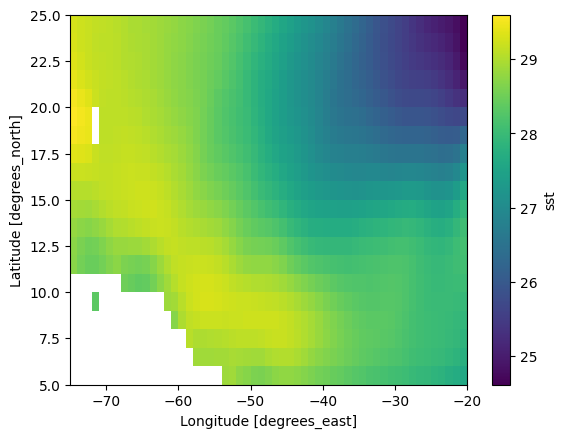

In [10]:
sst.mean("time").plot()

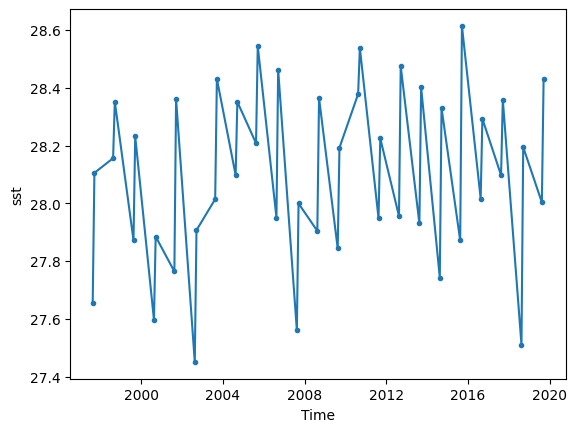

In [11]:
sst.mean("latitude").mean("longitude").plot(marker=".")

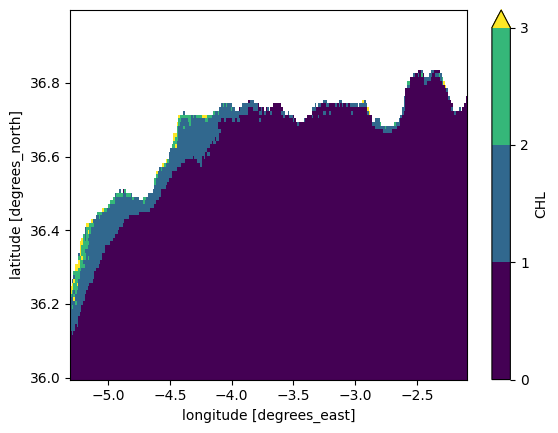

In [12]:
chl.mean("time").plot(levels=[0, 1, 2, 3])

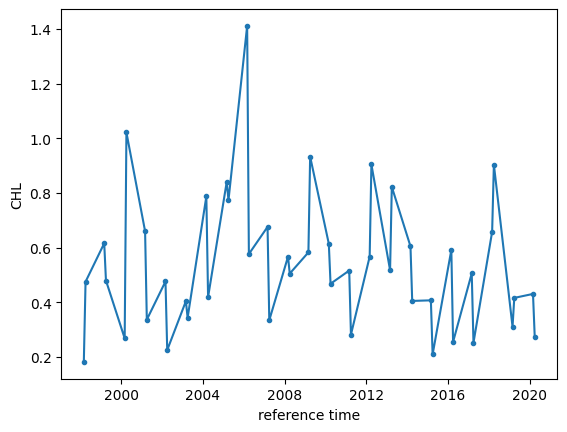

In [13]:
chl.mean("lat").mean("lon").plot(marker=".")

### 2. Preprocessing <a id="x-pre"></a>

In the preprocessing stage we need to calculate the anomalies of the seasonal mean and reshape the arrays into space x time matrices

In [14]:
# Given that the seasons only span one year we can take the yearly mean of the time axis
sst = sst.groupby("time.year").mean()
chl = chl.groupby("time.year").mean()

In [15]:
y = sst - sst.mean("year")
z = chl - chl.mean("year")

In [16]:
sst

<xarray.DataArray 'sst' (year: 23, latitude: 20, longitude: 55)> Size: 101kB
array([[[29.43972 , 29.324703, 29.236721, ..., 24.867073, 24.746378,
         24.540201],
        [29.501165, 29.34866 , 29.240013, ..., 24.92178 , 24.772491,
         24.51123 ],
        [29.448833, 29.289053, 29.198196, ..., 24.95534 , 24.78917 ,
         24.522488],
        ...,
        [      nan,       nan,       nan, ..., 27.690258, 27.562199,
         27.474775],
        [      nan,       nan,       nan, ..., 27.65865 , 27.54871 ,
         27.473726],
        [      nan,       nan,       nan, ..., 27.5221  , 27.39844 ,
         27.313917]],

       [[29.418564, 29.32129 , 29.19013 , ..., 24.786026, 24.727936,
         24.534008],
        [29.48762 , 29.362225, 29.229086, ..., 24.934086, 24.766254,
         24.50972 ],
        [29.513603, 29.374004, 29.264664, ..., 25.092678, 24.783533,
         24.475266],
...
        [      nan,       nan,       nan, ..., 27.841267, 27.778168,
         27.735716],
        [      nan,       nan,       nan, ..., 27.92116 , 27.866674,
         27.815903],
        [      nan,       nan,       nan, ..., 27.870008, 27.823608,
         27.764965]],

       [[29.059797, 29.13901 , 29.207676, ..., 25.025206, 24.790546,
         24.496622],
        [29.046814, 29.10406 , 29.170261, ..., 25.064781, 24.804836,
         24.45037 ],
        [29.062769, 29.085262, 29.128931, ..., 25.093243, 24.825397,
         24.447556],
        ...,
        [      nan,       nan,       nan, ..., 27.752783, 27.660511,
         27.626997],
        [      nan,       nan,       nan, ..., 27.764326, 27.68687 ,
         27.625046],
        [      nan,       nan,       nan, ..., 27.736523, 27.646976,
         27.557606]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 80B 24.5 23.5 22.5 21.5 ... 8.5 7.5 6.5 5.5
  * longitude  (longitude) float32 220B -74.5 -73.5 -72.5 ... -22.5 -21.5 -20.5
  * year       (year) int64 184B 1997 1998 1999 2000 ... 2016 2017 2018 2019
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [17]:
chl

<xarray.DataArray 'CHL' (year: 23, lat: 99, lon: 250)> Size: 2MB
array([[[0.21465224, 0.2473787 , 0.22719526, ..., 0.12090172,
         0.12297925, 0.1198298 ],
        [0.23239255, 0.22782484, 0.2263079 , ..., 0.12343679,
         0.11864622, 0.11867309],
        [0.2286636 , 0.20803559, 0.20788139, ..., 0.12761016,
         0.12068577, 0.12094864],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.16464871, 0.18137816, 0.18113448, ..., 0.310634  ,
         0.30567884, 0.29548663],
        [0.18559793, 0.18445052, 0.18071373, ..., 0.27648756,
         0.29144764, 0.27454275],
        [0.18167377, 0.17825404, 0.19277668, ..., 0.29028517,
         0.28167462, 0.28074667],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.13607499, 0.13884723, 0.13911843, ..., 0.11104058,
         0.11072575, 0.11365105],
        [0.14470449, 0.1443741 , 0.14499024, ..., 0.12129846,
         0.11603758, 0.11563934],
        [0.16214469, 0.1638612 , 0.17014524, ..., 0.14019011,
         0.12605241, 0.11876828],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 396B 36.0 36.01 36.02 36.03 ... 36.97 36.98 36.99
  * lon      (lon) float32 1kB -5.3 -5.287 -5.274 ... -2.126 -2.114 -2.101
  * year     (year) int64 184B 1998 1999 2000 2001 2002 ... 2017 2018 2019 2020
Attributes:
    long_name:      Monthly Multi-sensor and multi water-type Chlorophyll a c...
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    type:           surface
    units:          milligram m^-3
    cell_methods:   time: mean (interval: 1 month  comment: sampled instantan...
    valid_min:      0.01
    valid_max:      100.0
    source:         MODISA Aqua - Level2,VIIRSJ JPSS-1 - Level2,VIIRSN Suomi-...
    _ChunkSizes:    [   1  790 1654]

In [18]:
sst.shape

(23, 20, 55)

In [19]:
y = sst.values.reshape(sst.shape[0], sst.shape[1]*sst.shape[2]).T
z = chl.values.reshape(chl.shape[0], chl.shape[1]*chl.shape[2]).T

Apply detrending to the predictor field

In [20]:
y_land_mask = np.isnan(y.sum(axis=1))  # Masks where the land is
y[~y_land_mask] = signal.detrend(y[~y_land_mask])

In [21]:
z_land_mask = np.isnan(z.sum(axis=1))

### 3. Perform MCA <a id="x-mca"></a>

In [22]:
nm = 3  # Calculate up to 3 modes
alpha = 0.1  # Significance level for Pearson correlation

Calculate the convariance matrix

In [23]:
c = np.dot(y[~y_land_mask], np.transpose(z[~z_land_mask]))

Singular Value Decomposition

In [24]:
r, _d, q = sparse.linalg.svds(c, k=nm, which='LM')  # Which LM = Large magnitude

# Modes are reversed so we reverse them in r, d and q
r = r[:, ::-1]
_d = _d[::-1]
q = q[::-1, :]

svdvals = scipy.linalg.svdvals(c)
scf = svdvals[:nm] / np.sum(svdvals)

In [25]:
# Time series of covariability
u = np.dot(np.transpose(y[~y_land_mask]), r)
v = np.dot(np.transpose(z[~z_land_mask]), q.transpose())

Us = ((u - u.mean(0)) / u.std(0)).transpose()  # Standarized anom across axis 0
Vs = ((v - v.mean(0)) / v.std(0)).transpose()


Perform index regression to get the modes of variability

In [26]:
ny, nz = y.shape[0], z.shape[0]
nt = y.shape[1]  # Must be the same as z.shape[1]

RUY = np.zeros([ny, nm], dtype=np.float32)
SUY = np.zeros([ny, nm], dtype=np.float32)
pvalruy = np.zeros([ny, nm], dtype=np.float32)

RUZ = np.zeros([nz, nm], dtype=np.float32)
SUZ = np.zeros([nz, nm], dtype=np.float32)
pvalruz = np.zeros([nz, nm], dtype=np.float32)

RUY[y_land_mask, :] = np.nan
pvalruy[y_land_mask, :] = np.nan
             
RUZ[z_land_mask, :] = np.nan
pvalruz[z_land_mask, :] = np.nan

for i in range(nm):
    SUY[:, i] = y.dot(Us[i, :]) / nt    
    result = np.apply_along_axis(stats.pearsonr, 1, y[~y_land_mask], Us[i, :])
    RUY[~y_land_mask, i], pvalruy[~y_land_mask, i] = result[:, 0], result[:, 1]

    SUZ[:, i] = z.dot(Us[i, :]) / nt    
    result = np.apply_along_axis(stats.pearsonr, 1, z[~z_land_mask], Us[i, :])
    RUZ[~z_land_mask, i], pvalruz[~z_land_mask, i] = result[:, 0], result[:, 1]

RUY_sig = RUY.copy()
SUY_sig = SUY.copy()
RUY_sig[pvalruy > alpha] = np.nan
SUY_sig[pvalruy > alpha] = np.nan

RUZ_sig = RUZ.copy()
SUZ_sig = SUZ.copy()
RUZ_sig[pvalruz > alpha] = np.nan
SUZ_sig[pvalruz > alpha] = np.nan

### 4. Plot MCA <a id="x-plot"></a>

In [27]:
fig = plt.figure(figsize=(14, 8))

<Figure size 1400x800 with 0 Axes>

In [28]:
gs = gridspec.GridSpec(3, 3)

In [29]:
for i in range(nm):
    ax = fig.add_subplot(gs[i, 0])
    ax.plot(sst["year"].values, Us[i, :], color="green", label="Us")
    ax.plot(sst["year"].values, Vs[i, :], color="blue", label="Vs")
    if i == 0:
        ax.legend()

for i in range(nm):
    ax = fig.add_subplot(gs[i, 1], projection=ccrs.PlateCarree())
    
    ru, ru_sig, lats, lons = RUY, RUY_sig, sst["latitude"], sst["longitude"]
    t = ru[:, i].transpose().reshape((len(lats), len(lons)))
    th = ru_sig[:, i].transpose().reshape((len(lats), len(lons)))

    im = ax.contourf(
        lons, lats, t, cmap="bwr",
        extend='both', transform=ccrs.PlateCarree(),
    )
    ax.contourf(
        lons, lats, th, colors='none', hatches='..', extend='both',
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    fig.colorbar(im, ax=ax, orientation="horizontal")

for i in range(nm):
    ax = fig.add_subplot(gs[i, 2], projection=ccrs.PlateCarree())
    
    ru, ru_sig, lats, lons = RUZ, RUZ_sig, chl["lat"], chl["lon"]
    t = ru[:, i].transpose().reshape((len(lats), len(lons)))
    th = ru_sig[:, i].transpose().reshape((len(lats), len(lons)))

    im = ax.contourf(
        lons, lats, t, cmap="viridis",
        extend='both', transform=ccrs.PlateCarree(),
    )
    ax.contourf(
        lons, lats, th, colors='none', hatches='..', extend='both',
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    fig.colorbar(im, ax=ax, orientation="horizontal")

fig.suptitle("MCA")

Text(0.5, 0.98, 'MCA')

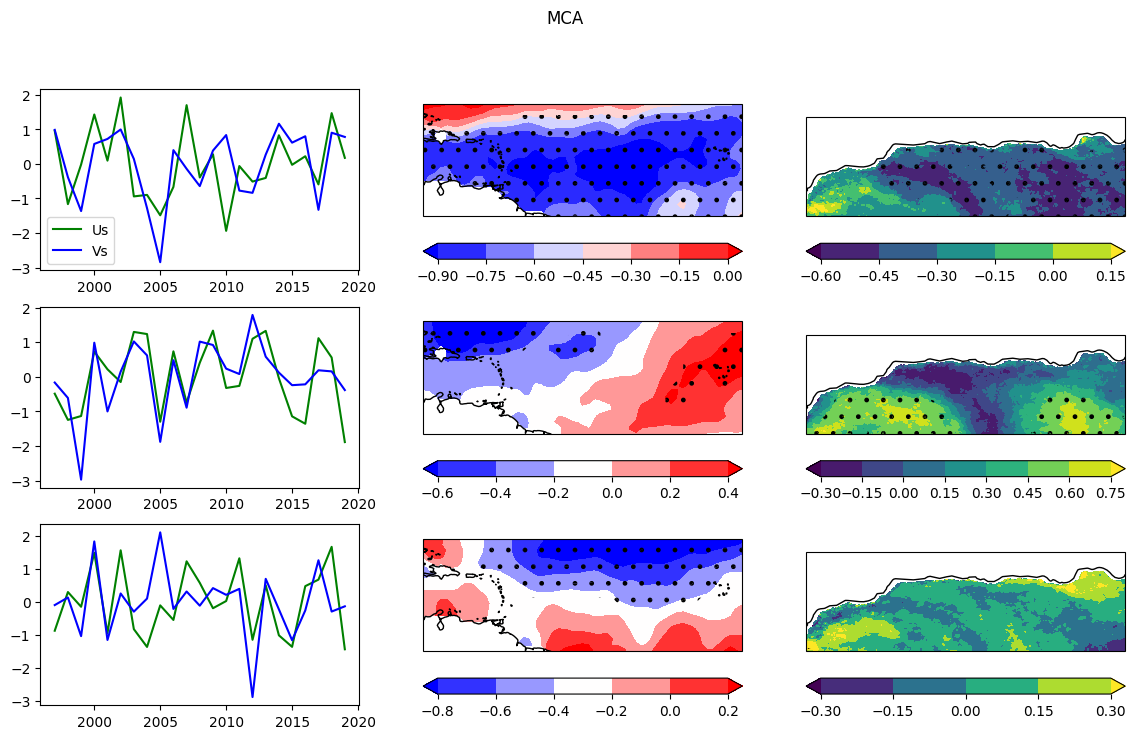

In [30]:
fig

## Using Spy4Cast <a id="spy4cast"></a>

In [31]:
from spy4cast import Dataset, Region, Month
from spy4cast.spy4cast import Preprocess, MCA, Crossvalidation

### 1. Configuration <a id="s-conf"></a>

Configuration is srtraight forward with the abstractions spy4cast provides.

This enhances productivity and makes it easier to change the parameters of the run. It is also quite straight-forward to 
declare seasons that span through a year like NDJ, which requires more logic with xarray


Also it provides a `skip` option to reduce the dimension of the dataset. This makes ir faster for the first runs and you can decrease it to 0 for the final output

In [55]:
predictor = Dataset(PREDICTOR_NAME, DATASET_DIR).open("sst")
sst_region = Region(
    lat0=5, latf=25,
    lon0=-75, lonf=-20,
    month0=Month.AUG, monthf=Month.SEP,
    year0=1997, yearf=2019,
)  # PREDICTOR: Y
predictor.slice(sst_region, skip=0)

predictand = Dataset(PREDICTAND_NAME, DATASET_DIR).open("CHL")
chl_region = Region(
    lat0=36, latf=37,
    lon0=-5.3, lonf=-2,
    month0=Month.MAR, monthf=Month.APR,
    year0=1998, yearf=2020,
)  # PRECITAND: Z
predictand.slice(chl_region, skip=0)

Climatology and anomaly plots can be created easily with `meteo.Clim` and `meteo.Anom` as well as time series

((<Figure size 1000x400 with 2 Axes>,), (<GeoAxesSubplot:>,))

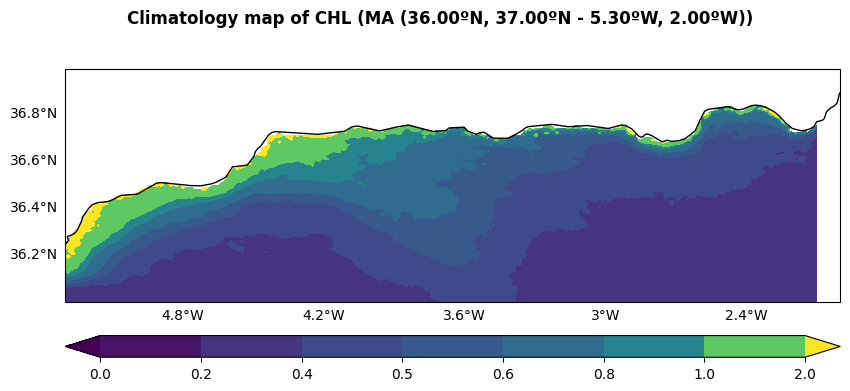

In [56]:
from spy4cast.meteo import Clim

Clim(predictand, "map").plot(levels=[0, .2, .4, .5, .6, .8, 1, 2], cmap="viridis", figsize=(10, 4))

### 2. Preprocessing <a id="s-pre"></a>

Preprocessing only takes one line, as everything we did before is included.

It also performs a Butterwirth filter if you provide the `period` and `order` keyword arguments. To do so it uses `scipy.signal.butter` along with `scipy.signal.filtfilt` functions along the time axis

In [59]:
predictor_preprocessed = Preprocess(predictor)
predictand_preprocessed = Preprocess(predictand)

[INFO] Preprocessing data for variable sst took: 0.031 seconds
[INFO] Preprocessing data for variable CHL took: 0.017 seconds


To visalize easily the region of both variables we can use `.plot` method. 

((<Figure size 800x400 with 2 Axes>,),
 (<GeoAxesSubplot:title={'center':'Year 2000'}>,))

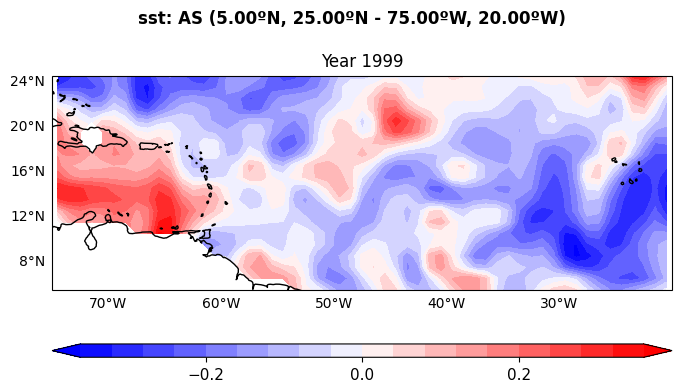

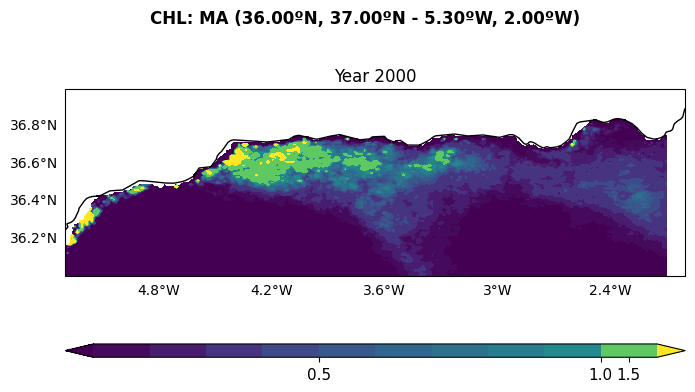

In [60]:
predictor_preprocessed.plot(selected_year=1999, figsize=(8, 4), levels=20)
predictand_preprocessed.plot(selected_year=2000, figsize=(8, 4), cmap="viridis", levels=[0, .1, .2, .4, .5, .6, .7, .8, .9, 1, 2])

To save the calculated matrices, spy4cast includes a convenient method in case there is an intention to share the results

In [61]:
DATA_FOLDER = 'step-by-step-tutorial/data/'
PREDICTOR_PREPROCESSED_PREFIX = 'predictor_'
PREDICTAND_PREPROCESSED_PREFIX = 'predictand_'

predictor_preprocessed.save(PREDICTOR_PREPROCESSED_PREFIX, DATA_FOLDER)
predictand_preprocessed.save(PREDICTAND_PREPROCESSED_PREFIX, DATA_FOLDER)

[INFO] Saving Preprocess data in `step-by-step-tutorial/data/predictor_*.npy`
[INFO] Saving Preprocess data in `step-by-step-tutorial/data/predictand_*.npy`


They will be saved in `.npy` format. Eventhough this format is not the best it promotes compatibility and it is flexible so that it can be used with any
other tools. In the future, if there is a demand from the users, it will be easy to move to any format it is suggested. To load the different matrices that
are saved only the `np.load` method is needed.

However, spy4cast has a more convenient function to get the same object you have saved from the previous call

This is useful to write code in the following manner:
```python
# Once these have been run we set to False and the program is faster
RUN_PREPROCESS_Y = True
RUN_PREPROCESS_Z = True

if RUN_PREPROCESS_Y:
    y = Preprocess(sst)
    y.save("y_", "data")
else:
    y = Preprocess.load("y_", "data")

if RUN_PREPROCESS_Z:
    z = Preprocess(chl)
    z.save("z_", "data")
else:
    z = Preprocess.load("z_", "data")

mca = MCA(y, z, 3, .1)
```

### 3. MCA <a id="s-mca"></a>

MCA is built into spy4cast. It performs the exact same methodology as before and returns a variable contaning all the matrices as before

This is very convenient for user experience as all the date is stored together

In [62]:
nm = 3
alpha = .1

mca = MCA(predictor_preprocessed, predictand_preprocessed, nm, alpha)

[INFO] Applying MCA 
    Shapes: Z(24750, 23) 
            Y(1100, 23) 
    Regions: Z MA (36.00ºN, 37.00ºN - 5.30ºW, 2.00ºW) 
            Y AS (5.00ºN, 25.00ºN - 75.00ºW, 20.00ºW)
       Took: 4.556 seconds


In [63]:
mca.var_names

('psi',
 'RUY',
 'RUY_sig',
 'SUY',
 'SUY_sig',
 'RUZ',
 'RUZ_sig',
 'SUZ',
 'SUZ_sig',
 'pvalruz',
 'pvalruy',
 'Us',
 'Vs',
 'scf',
 'alpha',
 'nm')

As in Preprocess, there is a method to save the data into `.npy` format. This is useful when the user needs to change the plots and wants to 
use the results without running the methodology again

As in Preprocess, it can be used the following way:
```python
RUN_PREPROCESS_MCA = True

if RUN_PREPROCESS_Y:
    mca = MCA(y, z, nm, alpha)
    mca.save("mca_", "data")
else:
    mca = MCA.load("mca_", "data", dsy=y, dsz=z)
```

In [64]:
MCA_PREFIX = 'mca_'

mca.save(MCA_PREFIX, DATA_FOLDER)
# mca = MCA.load(MCA_PREFIX, DATA_FOLDER, dsy=predictor_preprocessed, dsz=predictand_preprocessed)

[INFO] Saving MCA data in `step-by-step-tutorial/data/mca_*.npy`


### 4. Plot MCA <a id="s-plot"></a>

Plotting takes one command also and it is very easy to save the plots and to change the visulization

These plots must be used as a quick-diagnosis tool and not as a final result. We encourage users to write their own plot functions.

[INFO] Saving plot with path step-by-step-tutorial/plots/mca.png


((<Figure size 1400x800 with 11 Axes>,),
 (<AxesSubplot:title={'center':'Us Vs mode 1'}>,
  <AxesSubplot:title={'center':'Us Vs mode 2'}>,
  <AxesSubplot:title={'center':'Us Vs mode 3'}>,
  <GeoAxesSubplot:title={'center':'RUY mode 1. SCF=47.1%'}>,
  <GeoAxesSubplot:title={'center':'RUY mode 2. SCF=12.0%'}>,
  <GeoAxesSubplot:title={'center':'RUY mode 3. SCF=9.3%'}>,
  <GeoAxesSubplot:title={'center':'RUZ mode 1. SCF=47.1%'}>,
  <GeoAxesSubplot:title={'center':'RUZ mode 2. SCF=12.0%'}>,
  <GeoAxesSubplot:title={'center':'RUZ mode 3. SCF=9.3%'}>))

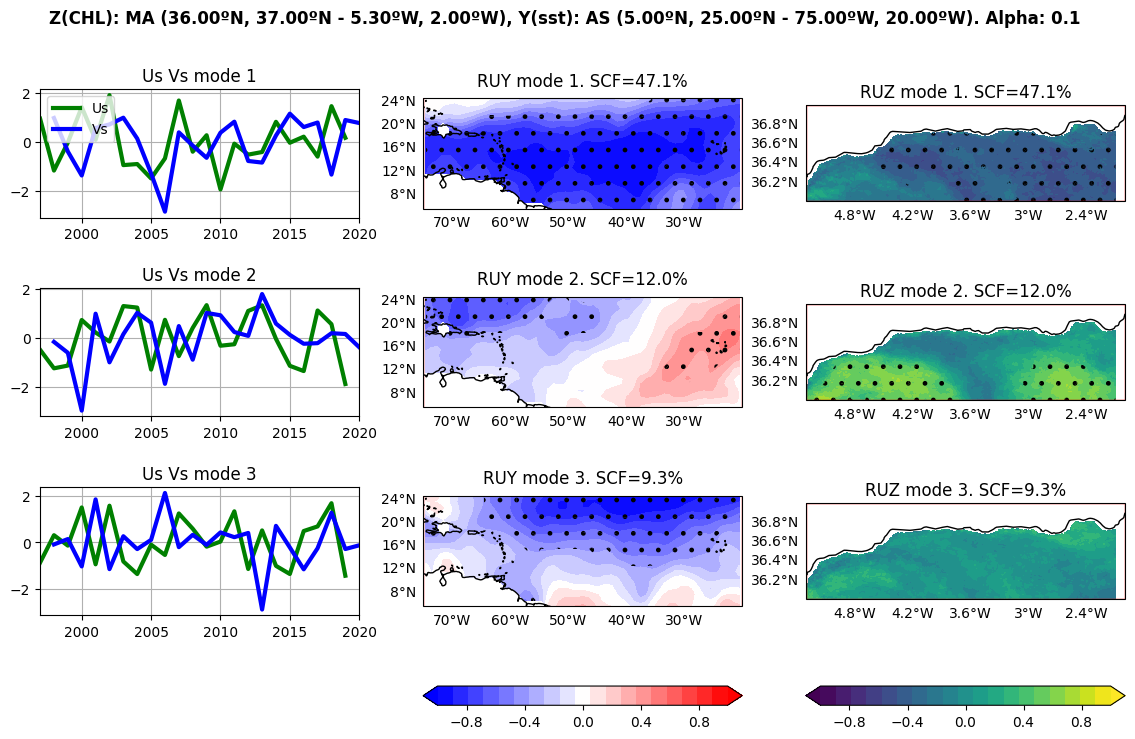

In [65]:
PLOTS_FOLDER = 'step-by-step-tutorial/plots'

MCA_PLOT_NAME = 'mca.png'

mca.plot(save_fig=True, cmap='viridis', name=MCA_PLOT_NAME, 
         figsize=(14, 8),
         width_ratios=[1, 1, 1],
         folder=PLOTS_FOLDER,)

### 5. Crossvalidation <a id="s-cross"></a>

Crossvalidation is the same as MCA but leaving one year out of the analysis. The code for xarray-MCA can be modified to run crossvalidation. 
Here we show how it is run with spy4cast. It has the same `.save`, `.load` and `.plot` functions as `MCA` 

In [66]:
cross = Crossvalidation(predictor_preprocessed, predictand_preprocessed, nm, alpha)

[INFO] Applying Crossvalidation 
    Shapes: Z(24750, 23) 
            Y(1100, 23) 
    Regions: Z MA (36.00ºN, 37.00ºN - 5.30ºW, 2.00ºW) 
            Y AS (5.00ºN, 25.00ºN - 75.00ºW, 20.00ºW)
	year: 1 of 23
	year: 2 of 23
	year: 3 of 23
	year: 4 of 23
	year: 5 of 23
	year: 6 of 23
	year: 7 of 23
	year: 8 of 23
	year: 9 of 23
	year: 10 of 23
	year: 11 of 23
	year: 12 of 23
	year: 13 of 23
	year: 14 of 23
	year: 15 of 23
	year: 16 of 23
	year: 17 of 23
	year: 18 of 23
	year: 19 of 23
	year: 20 of 23
	year: 21 of 23
	year: 22 of 23
	year: 23 of 23

	Took: 150.828 seconds


In [67]:
CROSS_PREFIX = 'cross_'

cross.save(CROSS_PREFIX, DATA_FOLDER)

[INFO] Saving Crossvalidation data in `step-by-step-tutorial/data/cross_*.npy`


In [68]:
# cross = Crossvalidation.load(CROSS_PREFIX, DATA_FOLDER, dsy=predictor_preprocessed, dsz=predictand_preprocessed)

[INFO] Saving plot with path step-by-step-tutorial/plots/cross.png


((<Figure size 1600x800 with 6 Axes>,),
 (<GeoAxesSubplot:title={'center':'ACC map'}>,
  <AxesSubplot:title={'center':'ACC time series'}>,
  <GeoAxesSubplot:title={'center':'RMSE map'}>,
  <AxesSubplot:title={'center':'RMSE time series'}>))

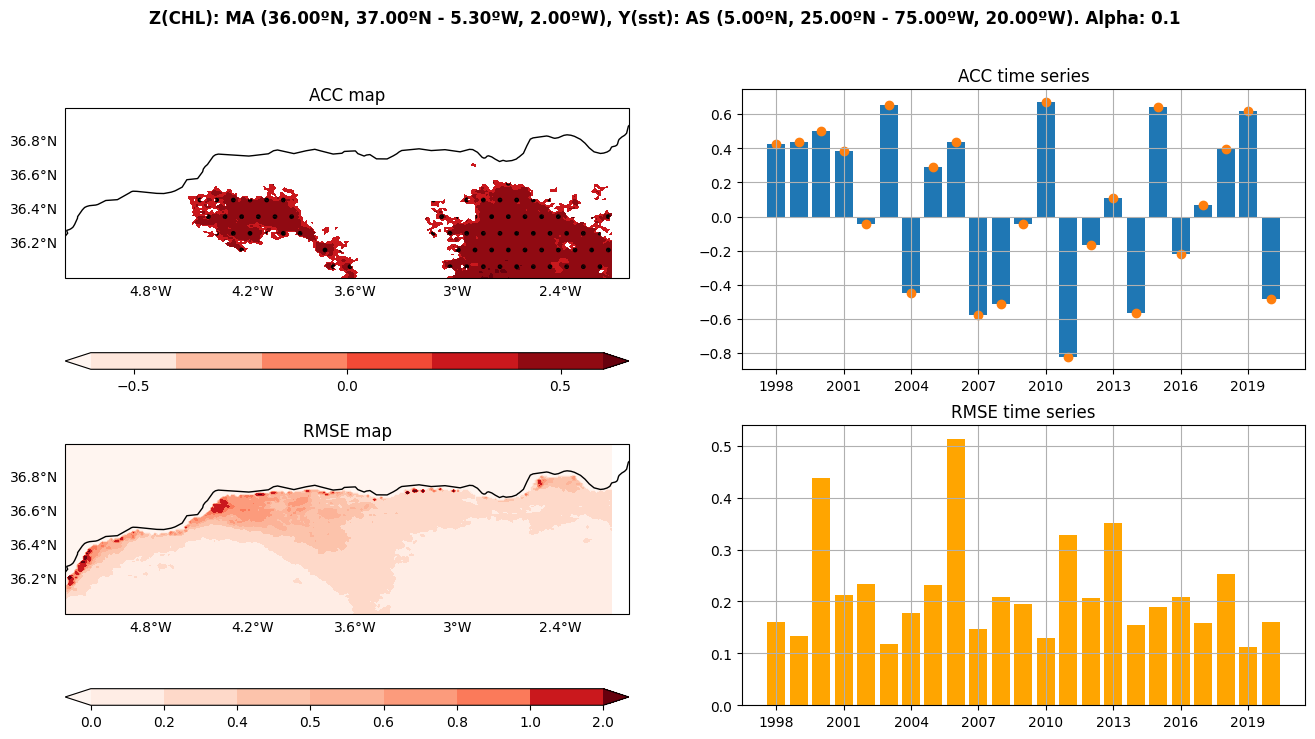

In [69]:
CROSS_PLOT_NAME = 'cross.png'

cross.plot(save_fig=True, folder=PLOTS_FOLDER, name=CROSS_PLOT_NAME, map_levels=[-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6], rmse_levels=[0, .2, .4, .5, .6, .8, 1, 2])

Crossvalidation provides a different version of diagnosis plot with `version=2` by which you also need to provide `mca=mca`

[INFO] Saving plot with path step-by-step-tutorial/plots/cross.png


((<Figure size 2400x850 with 16 Axes>,),
 (<AxesSubplot:title={'center':'Mode 1, |ruv|=0.50 p=0.985'}, xlabel='Years', ylabel='nº std'>,
  <AxesSubplot:title={'center':'Mode 1, |ruv|=0.50 , scf=47.10%'}, xlabel='Years', ylabel='|ruv|'>,
  <GeoAxesSubplot:title={'center':'ACC 1 modes'}>,
  <AxesSubplot:title={'center':'Skill (bars), \n MSESS (lines)'}>,
  <AxesSubplot:title={'center':'Mode 2, |ruv|=0.70 p=1.000'}, xlabel='Years'>,
  <AxesSubplot:title={'center':'Mode 2, |ruv|=0.70 , scf=11.96%'}, xlabel='Years'>,
  <GeoAxesSubplot:title={'center':'ACC 2 modes'}>,
  <GeoAxesSubplot:title={'center':'ACC [1 2]) - [1]'}>,
  <AxesSubplot:title={'center':'Mode 3, |ruv|=0.49 p=0.982'}, xlabel='Years'>,
  <AxesSubplot:title={'center':'Mode 3, |ruv|=0.49 , scf=9.26%'}, xlabel='Years'>,
  <GeoAxesSubplot:title={'center':'ACC 3 modes'}>,
  <GeoAxesSubplot:title={'center':'ACC [1 2 3]) - [1 2]'}>))

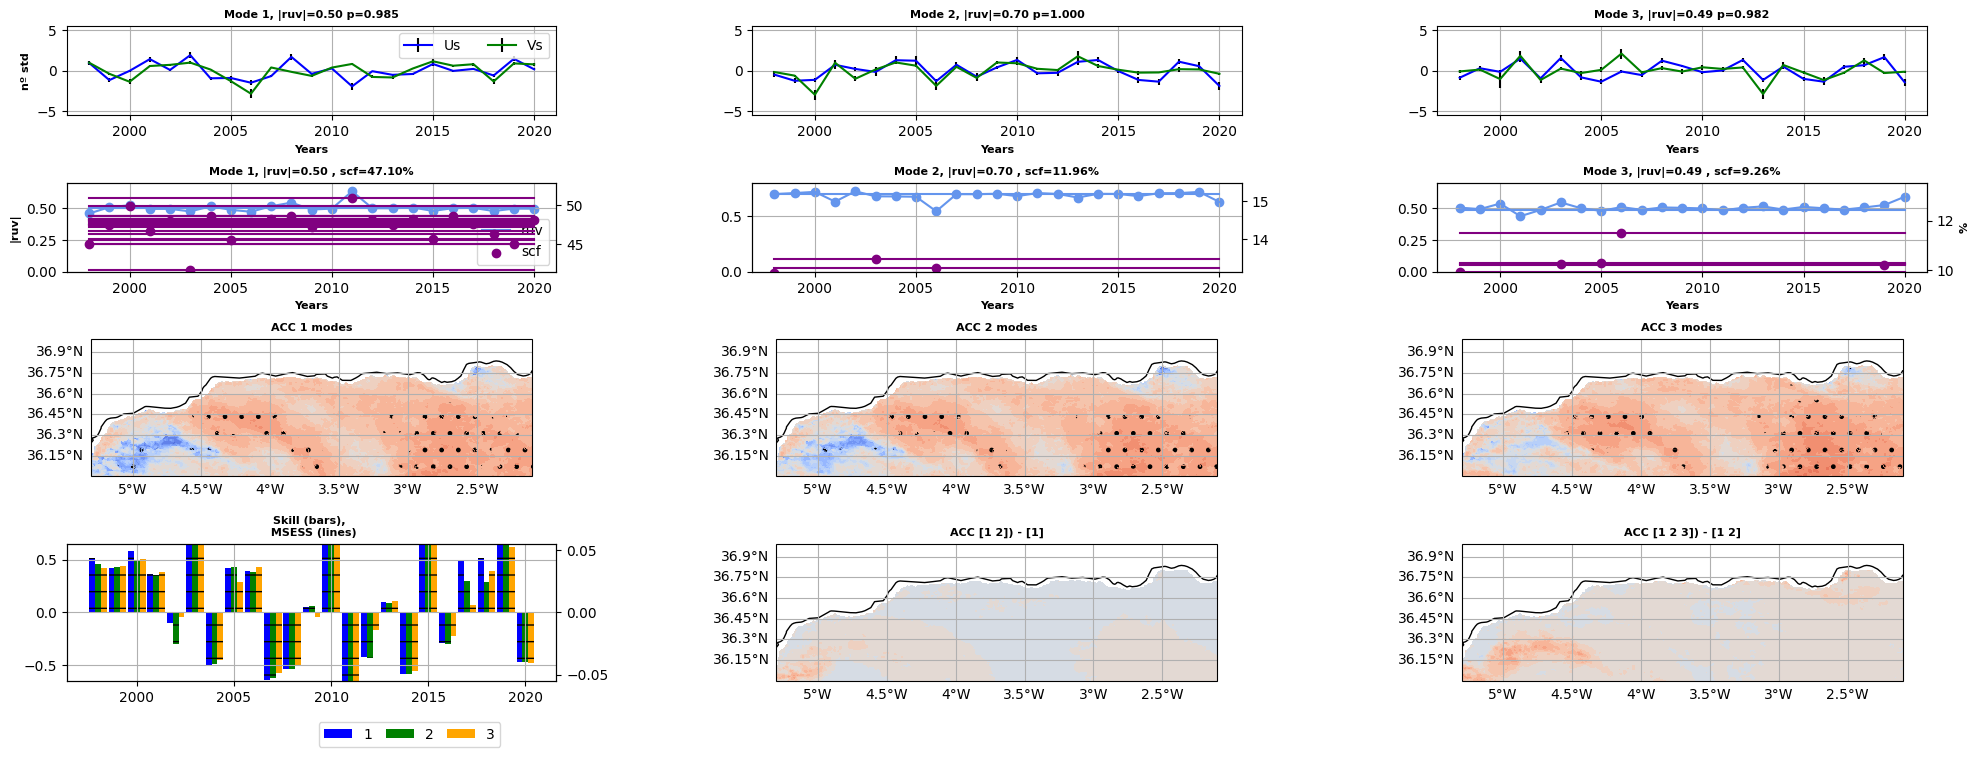

In [70]:
cross.plot(save_fig=True, folder=PLOTS_FOLDER, name=CROSS_PLOT_NAME, version=2, mca=mca)